In [14]:
import numpy as np
import pandas as pd
import math

In [2]:
def intersect_spehere(observer_vec, look_vec, sphere_rad):
    """
    Compute the intersection of a look vector from an observer with a sphere
    
    Parameters
    ----------
    observer_vec : array
                   The cartesian position of the observer
                   
    look_vec : array
               The cartesian look vector
                   
    sphere_rad : float
                 The radius of the sphere
    
    Returns
    -------
    array :
        The cartesian positon of the intersection or closest point on the infinite look vector if it doesn't intersect
    """
    # Use quadratic formula to find distance such that
    # norm(observer_vec + distance * look_vec) = sphere_rad
    a = look_vec[0]**2 + look_vec[1]**2 + look_vec[2]**2
    b = 2 * (observer_vec[0]*look_vec[0] + observer_vec[1]*look_vec[1] + observer_vec[2]*look_vec[2])
    c = observer_vec[0]**2 + observer_vec[1]**2 + observer_vec[2]**2 - sphere_rad**2
    discriminant = b**2 - 4.0 * a * c
    if discriminant < 0 :
        print('descriminant [{}] is negative, computing closest intersection...'.format(discriminant))
        discriminant = 0
    distance = (-b - np.sqrt(discriminant)) / (2 * a)
    return observer_vec + distance * look_vec

In [3]:
def generate_position_error(max_error):
    """
    Generate random pointing error
    
    Parameters
    ----------
    max_error : float
                The maximum magnitude of the error
                
    Returns
    -------
    array :
        The random error vector
    """
    mag = np.random.uniform(low=0, high=max_error)
    theta = np.random.uniform(low=0, high=2*np.pi)
    phi = np.random.uniform(low=0, high=2*np.pi)
    return mag * np.array([math.sin(theta) * math.cos(phi), math.sin(theta) * math.sin(phi), math.cos(theta)])

In [4]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    
    Shamelessly stolen from https://stackoverflow.com/questions/6802577/rotation-of-3d-vector
    """
    axis = axis / np.linalg.norm(axis)
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [60]:
def generate_pointing_error(look_vec, max_error):
    """
    Generate random pointing error
    
    Parameters
    ----------
    look_vec : array
               The look vector to generate error about
    
    max_error : float
                The maximum magnitude error in radians
                
    Returns
    -------
    array :
        The random error rotation matrix
    """
    # Generate an orthogonal vector
    look_norm = look_vec / np.linalg.norm(look_vec)
    # If the look is too close to (1, 0, 0), we need to add a different vector
    if abs(look_norm[0]) < 0.9 :
        offset = look_norm + np.array([1, 0 , 0])
    else:
        offset = look_norm + np.array([0, 1 , 0])
    orthogonal = offset - np.dot(offset, look_norm) * look_norm
    orthogonal = orthogonal / np.linalg.norm(orthogonal)
        
    # Rotate the orthogonal vector by a random amount
    ortho_rot = rotation_matrix(look_norm, np.random.uniform(low=0, high=2*np.pi))
    ortho_axis = np.dot(ortho_rot, orthogonal)
    
    # Return a random rotation around the orthogonal vector
    rotation_error = np.random.uniform(low=0, high=max_error)
    return rotation_matrix(ortho_axis, rotation_error), rotation_error

In [6]:
def intersect_with_position_error(observer_vec, look_vec, sphere_rad, max_error):
    """
    Intersect a sphere with random positional error
    """
    error = generate_position_error(max_error)
    observer_error = observer_vec + error
    intersection = intersect_spehere(observer_error, look_vec, sphere_rad)
    return intersection, np.linalg.norm(error)

In [61]:
def intersect_with_pointing_error(observer_vec, look_vec, sphere_rad, max_error):
    """
    Intersect a sphere with random pointing error
    """
    error, error_mag = generate_pointing_error(look_vec, max_error)
    look_error = np.dot(error, look_vec)
    intersection = intersect_spehere(observer_vec, look_error, sphere_rad)
    return intersection, error_mag

In [10]:
radius = 3396200
fly_height = 500000
position = np.array([radius + fly_height, 0, 0])
look = - position / np.linalg.norm(position)
n = 1000

## NADIR

In [21]:
nadir_position_error = {
    'ground_error' : [],
    'position_error' : []
}
no_error_point = intersect_spehere(position, look, radius)
max_error = 10
for i in range(n):
    intersection, error_mag = intersect_with_position_error(position, look, radius, max_error)
    nadir_position_error['ground_error'].append(np.linalg.norm(intersection - no_error_point))
    nadir_position_error['position_error'].append(error_mag)

In [62]:
nadir_pointing_error = {
    'ground_error' : [],
    'pointing_error' : []
}
no_error_point = intersect_spehere(position, look, radius)
max_pointing_error = math.pi/32
for i in range(n):
    intersection, error_mag = intersect_with_pointing_error(position, look, radius, max_pointing_error)
    nadir_pointing_error['ground_error'].append(np.linalg.norm(intersection - no_error_point))
    nadir_pointing_error['pointing_error'].append(error_mag)

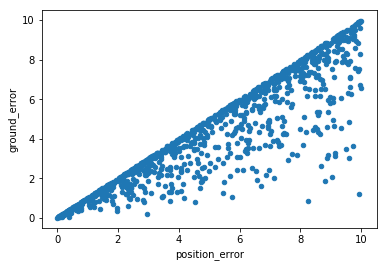

In [64]:
nadir_position_df = pd.DataFrame.from_dict(nadir_position_error)
nadir_position_df.plot(x='position_error', y='ground_error', kind='scatter')

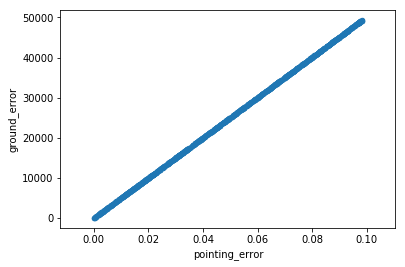

In [65]:
nadir_pointing_df = pd.DataFrame.from_dict(nadir_pointing_error)
nadir_pointing_df.plot(x='pointing_error', y='ground_error', kind='scatter')

## Oblique

In [69]:
off_nadir = math.pi/12
off_nadir_rotation = rotation_matrix(np.array([0, 1, 0]), off_nadir)
oblique_look = np.dot(off_nadir_rotation, look)
no_error_point = intersect_spehere(position, oblique_look, radius)

In [70]:
oblique_position_error = {
    'ground_error' : [],
    'position_error' : []
}
max_error = 10
for i in range(n):
    intersection, error_mag = intersect_with_position_error(position, oblique_look, radius, max_error)
    oblique_position_error['ground_error'].append(np.linalg.norm(intersection - no_error_point))
    oblique_position_error['position_error'].append(error_mag)

In [71]:
oblique_pointing_error = {
    'ground_error' : [],
    'pointing_error' : []
}
max_pointing_error = math.pi/32
for i in range(n):
    intersection, error_mag = intersect_with_pointing_error(position, oblique_look, radius, max_pointing_error)
    oblique_pointing_error['ground_error'].append(np.linalg.norm(intersection - no_error_point))
    oblique_pointing_error['pointing_error'].append(error_mag)

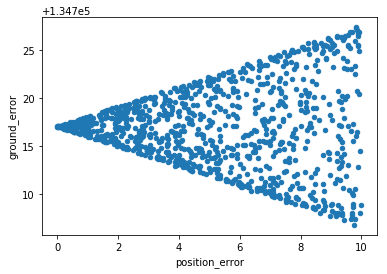

In [72]:
oblique_position_df = pd.DataFrame.from_dict(oblique_position_error)
oblique_position_df.plot(x='position_error', y='ground_error', kind='scatter')

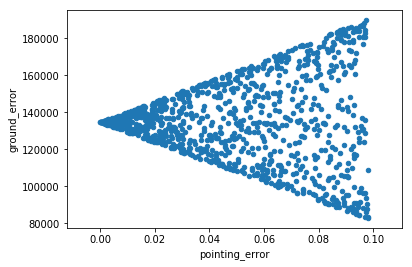

In [73]:
oblique_pointing_df = pd.DataFrame.from_dict(oblique_pointing_error)
oblique_pointing_df.plot(x='pointing_error', y='ground_error', kind='scatter')